In [1]:
'''Make possible for python notebooks to import the util as module. This needs to be copied at every python notebook which wants to 
load the module'''

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path


class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing Jupyter notebook from %s" % path)
                                       
        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)

        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]
    
sys.meta_path.append(NotebookFinder())

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import string

import nltk
import numpy as np

from nltk import FreqDist, word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd

In [20]:
import tm_assignment_util as util
myutilObj = util.util()

In [27]:
summary=util.X_Cases_Osha_Predict
stopwords=nltk.corpus.stopwords.words('english')
user_defined_stop_words=['employee','employees','worker','workers','fall','falls','shock','amputation','employee']                    
new_stop_words=stopwords+user_defined_stop_words
occupations=['subcontractor','foreman','engineer','representative','director','manager','painter','builder','mason'
             ,'firefighter','fireman','driver','sweeper','singer','passenger','ranger','contractor','carpenter','yardmaster','groundsman'
            ,'herder','scientist','keeper','patroller', 'locksmith','trainer','skier','dealer','crewmember','flagman','brakeman','electrician'
            ,'crewman','linemen','operator']

grammar = r"""
  NP: {<NN>}
  {<NNS>}
  {<NN+>}
  {<NNP>}
  {<NNPS>}
"""

cp = nltk.RegexpParser(grammar)
occupations_list = [] 

noun_phrase_count=0
for word in summary:
    # Convert all characters to Lower case
    text=word.lower()
    token = nltk.word_tokenize(text)
    token=[word.lower() for word in token if word not in new_stop_words]
    token=[word.lower() for word in token if word in occupations]
    pos_tagged_preProcess = nltk.pos_tag(token)
    nouns = cp.parse(pos_tagged_preProcess)
    for subtree in nouns.subtrees(filter=lambda t: t.label() == 'NP'):
        noun_phrase_count=noun_phrase_count+1
        occupations_list.append(' '.join(word for word,postype in subtree.leaves()))
           
        break

freqdist=FreqDist(occupations_list)
print(freqdist)






<FreqDist with 33 samples and 3845 outcomes>


In [28]:

rslt = pd.DataFrame(freqdist.most_common(10),
                    columns=['Occupation', 'Frequency']).set_index('Occupation')

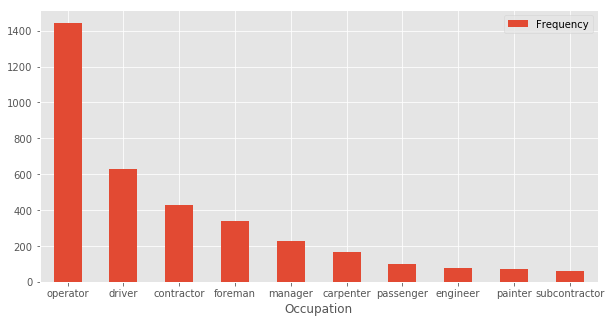

In [36]:
matplotlib.style.use('ggplot')
rslt.plot.bar(rot=0, figsize=(10,5))
plt.show()

In [33]:
freqdist=FreqDist(occupations_list)

In [34]:
print(freqdist)

<FreqDist with 33 samples and 3845 outcomes>


In [35]:
freqdist

FreqDist({'brakeman': 11,
          'builder': 10,
          'carpenter': 165,
          'contractor': 426,
          'crewman': 1,
          'crewmember': 4,
          'dealer': 7,
          'director': 17,
          'driver': 627,
          'electrician': 36,
          'engineer': 79,
          'firefighter': 43,
          'fireman': 8,
          'flagman': 15,
          'foreman': 339,
          'groundsman': 5,
          'herder': 1,
          'keeper': 15,
          'linemen': 5,
          'manager': 229,
          'mason': 24,
          'operator': 1443,
          'painter': 73,
          'passenger': 102,
          'patroller': 2,
          'ranger': 7,
          'representative': 36,
          'scientist': 6,
          'singer': 1,
          'skier': 3,
          'subcontractor': 61,
          'sweeper': 29,
          'trainer': 15})

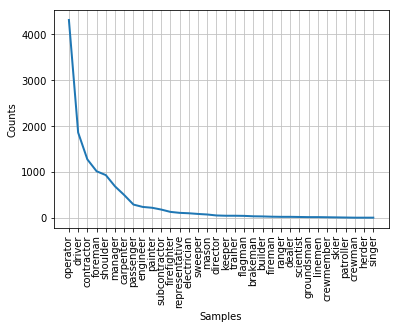

In [88]:
from nltk import FreqDist
fd_num = FreqDist(freqdist)
fd_num.plot()